In [1]:
%matplotlib inline

In [2]:
import os
import pandas as pd
import h5py
import urllib.request
import numpy as np
import seaborn as sns
import tqdm
import matplotlib.pyplot as plt

import parsl

In [3]:
from aspire import config
parsl.load(config)

In [4]:
num_samples = 10000
chunk_size = 5
store = 'store.h5'

In [8]:
def quantile_normalize(df):
    """
    see https://stackoverflow.com/questions/37935920/quantile-normalization-on-pandas-dataframe
    """
    
    rank_mean = df.stack().groupby(df.rank(method='first').stack().astype(int)).mean()
    
    return df.rank(method='min').stack().astype(int).map(rank_mean).unstack()

**Download expression data from archs4**

For more info: https://amp.pharm.mssm.edu/archs4/help.html

In [9]:
url = "https://s3.amazonaws.com/mssm-seq-matrix/human_matrix.h5"
if not os.path.isfile(os.path.basename(url)):
    urllib.request.urlretrieve(url, os.path.basename(url))

In [10]:
file = h5py.File('human_matrix.h5', 'r')

In [45]:
samples = file['meta']['Sample_geo_accession']
tissue = file['meta']['Sample_source_name_ch1']
genes = list(x.decode() for x in file['meta']['genes'])
# Data has sample rows and gene columns
# We need to pick `num_samples` rows-- preferably without loading the entire dataset into memory.
# I'm having trouble getting h5py to accept a random sample of indices (even sorted)-- for now, just
# pick every n'th row (not random, but fast)
data = pd.DataFrame(file['data']['expression'][::int(len(samples) / num_samples),:], columns=genes)

In [46]:
library = {}
with open('libraries/KEGG_2015.txt') as f:
    for line in f:
        parts = line.strip().split('\t')
        library[parts[0]] = [x.strip() for x in parts[2:]]

In [47]:
# Only examine genes that appear in at least one gene set
# Otherwise, the ROC is undefined
genes = list(set(sum(library.values(), [])).intersection(genes))

In [48]:
# Put the quantile-normalized data in an HDF5 store, so that concurrent processes can read from it
quantile_normalize(data[genes]).to_hdf(store, key='normalized_data', mode='w')

In [49]:
@parsl.python_app
def calculate_auc(gene_chunk, genes, library, store):
    import pandas as pd
    import sklearn.metrics
    import h5py
    
    normalized_data = pd.read_hdf(store, 'normalized_data')
    G = pd.DataFrame(index=gene_chunk, columns=library.keys())
    GM = pd.DataFrame(index=gene_chunk, columns=library.keys())
    result = []
    for gene in gene_chunk:
        for gene_set in library:
            intersection = set(library[gene_set] + [gene]).intersection(genes)
            correlation = normalized_data[intersection].corr().loc[gene]
            GM.loc[gene, gene_set] = correlation[correlation.index != gene].mean()
            G.loc[gene, gene_set] = 1 if gene in library[gene_set] else 0
            
        true = G.loc[gene].values.astype(int)
        score = GM.loc[gene].values.astype(float)
        result += [sklearn.metrics.roc_auc_score(true, score)]
    
    return result

In [50]:
futures = []
chunks = [genes[x:x + chunk_size] for x in range(0, len(genes), chunk_size)]
for gene_chunk in tqdm.tqdm_notebook(chunks):
    futures += [calculate_auc(gene_chunk, genes, library, os.path.abspath(store))]

In [59]:
aucs = lambda: sum([f.result() for f in futures if f.done()], [])

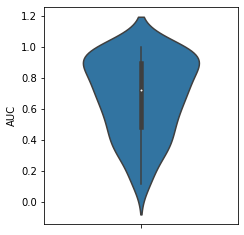

In [63]:
ax = sns.violinplot(x=aucs(), orient='v', width=0.6)
ax.set_ylabel('AUC')
ax.set_aspect(0.8)

In [74]:
print('{} genes processed, median AUC: {:.3f}'.format(len(aucs()), np.median(aucs())))

810 genes processed, median AUC: 0.787


In [ ]:
import time
for i in range(100):
    time.sleep(10)
    print('{} genes processed, median AUC: {:.3f}'.format(len(aucs()), np.median(aucs())))

In [ ]:
fig = ax.get_figure()
fig.savefig('auc.pdf')